In [1]:
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# progress bar
from tqdm import tqdm

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In this notebook, we explore the the level of noise in the information footprint that results from the so-called hitchhiking effect as well as how it scales as a function of library size. 


## Plotting average signal and average noise as a function of library size

In [2]:
## Loading WT promoter sequence

# Promoter
lacWT = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequences
O1 = 'AATTGTGAGCGGATAACAATT'

_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv('../data/ecoli_gene_list.csv')
lacO1_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
lacO1 = tregs.seq_utils.get_regulatory_region(genome, lacO1_TSS, reverse=True)

In [3]:
## Loading and fixing the RNAP energy matrix
rnap_emat_raw = np.loadtxt('../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, lacWT)

## Loading and fixing the lacI energy matrix
O1_1027_raw = np.load('../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], O1)
O1_emat = np.mean(O1_1027_fixed, axis=0)

In [4]:
## specifying parameters
n_NS = len(genome)
n_p = 4600
n_r = 10

ep_wt = -5
er_wt = -15

nbins = 2
upper_bound = 5

In [17]:
def simulate(n_seqs, nbins, upper_bound):
    df = tregs.simulate.simrep(lacO1, lacWT, O1, rnap_emat, O1_emat, 
                                ep_wt, er_wt, n_NS, n_p, n_r, num_mutants=n_seqs)
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data,
                                                    lacO1, nbins, upper_bound)
    return footprint


from itertools import compress

def combine_regions(regions):

    regions = sorted(regions)
    # sorting is necessary: the rest of the function does not work if list is not sorted

    combined_regions = []
    i = 0
    while i < len(regions):
        start = regions[i][0]
        tmp_end = regions[i][1]
        tmp_index = i
        for j in range(i+1, len(regions)):
            if regions[j][0] <= tmp_end:
                tmp_end = regions[j][1]
                tmp_index = j
        combined_regions.append((start, tmp_end))
        i = tmp_index + 1

    return combined_regions


def find_binding_sites(heights, smoothing_winsize, windowsize, stepsize,
                       min_ratio=2):
    cut = int((smoothing_winsize - 1) / 2)
    avg_height = np.mean(heights)

    position = 0
    window_ratio = []
    positions = []
    while position <= (len(heights) - windowsize):
        window = heights[position:(position + windowsize)]
        window_avg = np.mean(window)
        window_ratio.append(window_avg / avg_height)
        positions.append((position - 115 + cut, position + windowsize - 115 + cut))
        position += stepsize

    peak_windows = list(compress(positions, np.asarray(window_ratio) >= min_ratio))
    binding_sites = combine_regions(peak_windows)
    return binding_sites

[(-38, -29), (-15, -4), (3, 11)]


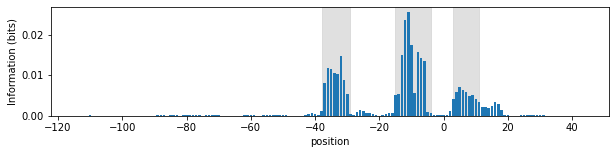

In [7]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
nbins = 2
upper_bound = 10
n_seqs = 10000
footprint = simulate(n_seqs, nbins, upper_bound)

binding_sites = find_binding_sites(footprint, smoothing_winsize=windowsize, windowsize=2, stepsize=1, min_ratio=2)
print(binding_sites)
for binding_site in binding_sites:
        ax.axvspan(binding_site[0], binding_site[1], alpha=0.7, color='lightgray')
ax.bar(x, footprint, edgecolor=None)

plt.show()

[(-38, -29), (-15, -4), (2, 12)]


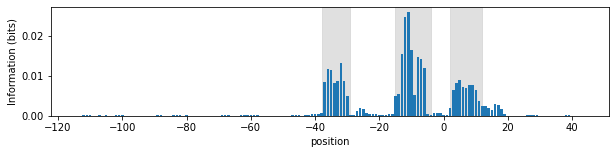

In [9]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
nbins = 2
upper_bound = 10
n_seqs = 10000
footprint = simulate(n_seqs, nbins, upper_bound)

binding_sites = find_binding_sites(footprint, smoothing_winsize=windowsize, windowsize=2, stepsize=1, min_ratio=2)
print(binding_sites)
for binding_site in binding_sites:
        ax.axvspan(binding_site[0], binding_site[1], alpha=0.7, color='lightgray')
ax.bar(x, footprint, edgecolor=None)

plt.show()

[(-37, -29), (-15, -5), (3, 12)]


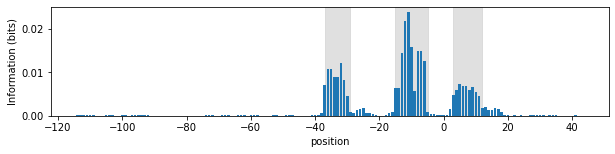

In [18]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
nbins = 2
upper_bound = 10
n_seqs = 10000
footprint = simulate(n_seqs, nbins, upper_bound)

binding_sites = find_binding_sites(footprint, smoothing_winsize=windowsize, windowsize=1, stepsize=1, min_ratio=2)
print(binding_sites)
for binding_site in binding_sites:
        ax.axvspan(binding_site[0], binding_site[1], alpha=0.7, color='lightgray')
ax.bar(x, footprint, edgecolor=None)

plt.show()

In [19]:
binding_sites = np.asarray(binding_sites) + 114
binding_sites

array([[ 77,  85],
       [ 99, 109],
       [117, 126]])

In [21]:
footprint[77:85]

array([0.00701361, 0.0107502 , 0.01085639, 0.00890688, 0.00896505,
       0.01215896, 0.00819306, 0.00458634])

In [24]:
footprint[85:]

array([9.55738522e-04, 6.10651556e-04, 1.42922169e-03, 1.66270417e-03,
       1.68635024e-03, 7.27524442e-04, 5.41710336e-04, 3.40251038e-04,
       2.47241469e-04, 5.61189020e-05, 6.22301633e-05, 2.67082906e-04,
       7.28944169e-04, 9.73588159e-04, 6.35871007e-03, 6.35825468e-03,
       1.45178024e-02, 2.17592935e-02, 2.38807314e-02, 1.59682120e-02,
       5.63096029e-03, 1.49061879e-02, 1.49405709e-02, 1.27150203e-02,
       9.54727086e-04, 5.22779664e-04, 3.06742234e-04, 2.37527178e-04,
       1.82294110e-04, 2.19190735e-04, 2.41796916e-04, 1.48539150e-03,
       4.77629502e-03, 6.03867473e-03, 7.40221306e-03, 6.91834095e-03,
       6.76424719e-03, 5.92456214e-03, 6.58813637e-03, 5.51179865e-03,
       4.65581717e-03, 1.85378173e-03, 2.05723250e-03, 1.40627227e-03,
       1.23944195e-03, 1.78244257e-03, 1.47695679e-03, 9.75065910e-04,
       1.55496141e-04, 1.84792680e-04, 5.99954923e-05, 9.75110151e-05,
       6.83701306e-05, 6.94215507e-05, 8.26120621e-06, 4.49914418e-05,
      